In [7]:

import networkit as nk
import networkx as nx

In [12]:
import pickle
with open("null_graphs", 'rb') as f:
    get_null_graphs = pickle.load(f)

In [13]:
import copy

# Takes in a list of characters from {N,F,P} and a graph with 
# edge curvature attribute. Returns the number of paths from 
# each node with the curvature pattern specified by the input list.
# N means negative curvature, F means neutral curvature, and P 
# means positive curvature. We consider an edge's curvature value to 
# be negative when between [-1, -0.33), flat 
# when between [-0.33, 0.33], and positive when between (0.33,1]. 
# E.g. A sequence of edges with curvatures -0.3, .56, 0 respectively
# would match the input pattern [F, P, F].
def get_paths(G, patt):
    
    # If pattern is empty then there are no matches
    if len(patt) == 0:
        return 0
    else:
        
        # Collects all paths
        all_paths = []
        for x in G.nodes():
            
            # Iteratively puts all_paths back intro function call
            # to append new paths.
            get_paths_helper(G, patt, all_paths, [x], x)
        return all_paths


# Input is a graph, the remaining curvature pattern to be matched, 
# a list to store all the paths, a variable that stores the current path 
# as a sequence of vertices during the recursive work, and the current vertex. 
# Adds paths that, building off of the current path, completely match 
# input pattern to the list of all paths.
# E.g. When cur_path is [v1, v2, v3] and there is an edge (v3, v4) with
# curvature -0.6 and another edge (v4, v5) with curvature 0.1 and another 
# edge (v4, v6) with curvature 0.2 and the remaining pattern is [N, F] then 
# we will add the paths [v1, v2, v3, v4, v5] and [v1, v2, v3, v4, v6] to 
# our total paths list.
def get_paths_helper(G, patt, all_paths, cur_path, cur_vert):
    
    # Base case. When the pattern is empty, the current path is 
    # added to the list of all paths since the current path
    # matched the initial input pattern.
    if len(patt) == 0:
        all_paths.append(copy.copy(cur_path)) 
    else:
        
        # If pattern is not exhausted, then for each neighbor of the
        # current vertex, see if the edge to any of its neighbors
        # matches the next curvature value in the pattern. If so repeat
        # the procedure on those nodes.
        for neighbor in G.neighbors(cur_vert):
            
            # This prevents the algorithms from finding all the walks.
            # We do not want vertices repeated in a path.
            if neighbor in cur_path:
                continue
            
            # Stores the curvature of the edge from the current vertex 
            # to the particular neighbor
            curv = G.get_edge_data(cur_vert, neighbor)['ricciCurvature']
            
            # Condition checks whether the sign of the curvature on the edge
            # matches the corresponding character of the next pattern element.
            if ((patt[0] == 'N') and (curv < -0.33)) or ((patt[0] == 'P') and (curv > 0.33)) or ((patt[0] == 'F') and (curv <= 0.33) and (curv >= -0.33)):
                
                # If the edge has a curvature of the matching sign then
                # the neighbor node is added to the current path.
                cur_path.append(neighbor)
                
                # We recurse on the neighbor node
                get_paths_helper(G, patt[1:], all_paths, cur_path, neighbor)
                
                # We remove the current neighbor node for the next iteration 
                # so we can consider a different neighbor node.
                cur_path.pop()
    return  

# Returns the number of paths in direcyed input graph that 
# match the curvature pattern specified by the variable patt.
def get_num_paths_dir(G, patt):
    all_paths = get_paths(G, patt)
    return len(all_paths)


In [9]:
# Installs necessary modules
!pip install GraphRicciCurvature
!pip install scikit-learn

# import sys
# sys.path.append("../")
import networkx as nx
import networkit as nk
import numpy as np
import math

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# load python-louvain for modularity computation
import community as community_louvain

# for ARI computation
from sklearn import preprocessing, metrics

In [15]:
# Returns the number of null graphs 
def null_graphs():
    null_graphs = []
    with open("null_graphs", 'rb') as f:
        null_graphs = pickle.load(f)
    return null_graphs

In [16]:
# Reads in C. Elegans Connectome
eleCme = nx.read_graphml("c.elegans_neural.male_1.graphml")

# Self loops are removed since no self loop can be on any path.
# The ricci curvature computation would remove self loops anyway
# so it is best to remove them beforehand. This way when we compute
# random graphs we are not removing a potentially different
# number of self loops each time to compute the curvature.
self_loops = []
for (v, w) in eleCme.edges():
    if v == w:
        self_loops.append(v)
for v in self_loops:
    eleCme.remove_edge(v,v)
    
# Computes Ricci Curvature for C. Elegans Connectome without self-loops
orc = OllivierRicci(eleCme, alpha=0.5, verbose="TRACE")
orc.compute_ricci_curvature()
eleCme_orc = orc.G.copy()

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 272
TRACE:Number of edges: 4388
TRACE:Start to compute all pair shortest path.
TRACE:0.010150 secs for all pair by NetworKit.
INFO:0.382386 secs for Ricci curvature computation.


In [17]:
# Returns list of all shortest paths. A
# path is given by the list of sequential 
# vertices that appear in that path.
def get_all_shortest_paths(G_orc):
    
    # Gets dictionary of all shortest path
    shortest_paths= nx.shortest_path(G_orc)
    
    # Converts that dictionary into a list
    all_shortest_paths = []
    for source in shortest_paths.keys():
        for target in shortest_paths[source].keys():
            all_shortest_paths.append(shortest_paths[source][target])
    return all_shortest_paths


# Given a graph with computed olliver-ricci
# curvature computes number of matches
# for each curvature pattern. Returns
# a dictionary mapping a pattern
# to the number of its matches.
def count_short_patterns(G_orc):
    
    # Gets list of all shortest paths
    all_shortest_paths = get_all_shortest_paths(G_orc)
    
    # For each path increments the pattern it matches
    # to count number of matches for each pattern
    count_short_patt = {}
    for path in all_shortest_paths:
        curr_patt = []
        for i in range(0, len(path)-1):
            curv = G_orc.get_edge_data(path[i], path[i+1])['ricciCurvature']
            if curv < -0.33:
                curr_patt.append('N')
            elif curv > 0.33:
                curr_patt.append('P')
            else:
                curr_patt.append('F')
                
        # Increments number of times the given pattern appears
        if tuple(curr_patt) in count_short_patt.keys():
            count_short_patt[tuple(curr_patt)] = count_short_patt[tuple(curr_patt)] + 1
        else: 
            count_short_patt[tuple(curr_patt)] = 1
    return count_short_patt

In [18]:
# Input is a graph with copmuted Ollivier-Ricci
# curvature. Gets those patterns which match 
# at least 1% of shortest paths.
def get_relevant_patterns(G_orc):
    count_short_patt = count_short_patterns(G_orc)
    
    # Gets number of shortest paths overall
    total_short_paths = len(get_all_shortest_paths(G_orc))
    
    relevant_patts = []
    
    # Checks for each pattern if it
    # matches over 1% of shortest paths.
    for patt in count_short_patt.keys():
        if count_short_patt[patt]/ total_short_paths >= 0.01:
            relevant_patts.append(patt)
            
    return relevant_patts

In [19]:
orc = OllivierRicci(eleCme, alpha=0.5, verbose="TRACE")
orc.compute_ricci_curvature()
count_short_patt = count_short_patterns(eleCme_orc)
relevant_patterns = get_relevant_patterns(eleCme_orc)

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
TRACE:Number of nodes: 272
TRACE:Number of edges: 4388
TRACE:Start to compute all pair shortest path.
TRACE:0.015646 secs for all pair by NetworKit.
INFO:0.351523 secs for Ricci curvature computation.


In [23]:
import copy 

# For each pattern that appears in over 1% of shortest paths
# returns a dictionary from a pattern to the number of times 
# the pattern was matched in the first n null graphs stored 
# in the null graph file. 
def get_relevant_null_dist(n):
    
    # Initializes a dcitonary where each pattern that appears in 
    # over 1% of C. Elegans shortest paths is a key with initially
    # an empty list assigned.
    null_dist = {key: [] for key in relevant_patterns}
    
    # For each of the first n null graphs...
    for null_graph in null_graphs()[0:n]:
        
        # Computes OllivierRicci curvature of the edges
        orc = OllivierRicci(null_graph, alpha=0.5, verbose="TRACE")
        orc.compute_ricci_curvature()
        G_orc = orc.G.copy()
        
        # Counts number of shortest paths matching each pattern
        count_short_patt = count_short_patterns(G_orc)
        
        # Appends the number of matches for each pattern in 
        # current null graph
        for patt in relevant_patterns:
            if patt in count_short_patt.keys():
                null_dist[patt].append(count_short_patt[patt])
            else:
                null_dist[patt].append(0)
    return null_dist

In [27]:
# Stores the number of matches for each null graph in a file. 
# Commented out since only needs to be computed once.

#start = timeit.default_timer()
#null_dist = get_relevant_null_dist(1000)
#with open("null_dist_shortest_path_elegans", 'wb') as f:
#    pickle.dump(null_dist, f)
    
#stop = timeit.default_timer()
#execution_time = stop - start
#print(execution_time)

# Returns the dictionary storing the number of matches 
# for each pattern for null graph. 
def null_dist():
    null_dist = {}
    with open("null_dist_shortest_path_elegans", 'rb') as f:
        null_dist = pickle.load(f)
    return null_dist

In [20]:
relevant_patterns

[('F',),
 ('F', 'F'),
 ('F', 'N'),
 ('F', 'F', 'F'),
 ('F', 'F', 'N'),
 ('F', 'N', 'F'),
 ('F', 'F', 'F', 'F'),
 ('F', 'F', 'F', 'N'),
 ('F', 'F', 'N', 'F'),
 ('F', 'N', 'F', 'F'),
 ('F', 'F', 'F', 'F', 'F'),
 ('N', 'F'),
 ('N', 'F', 'F')]

## Visualizing Pattern Match Distributions

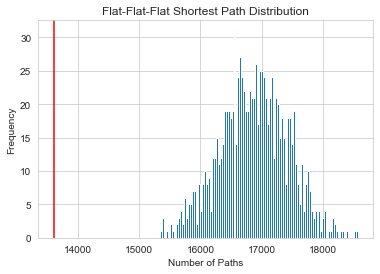

In [29]:
plt.hist(null_dist()[('F', 'F', 'F')], 100)
plt.title("Flat-Flat-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'F')], color = 'r')

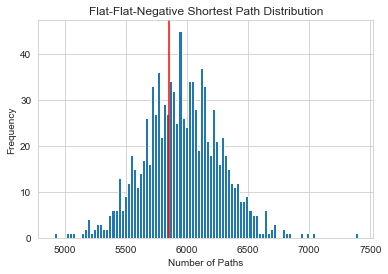

In [30]:
plt.hist(null_dist()[('F', 'F', 'N')], 100)
plt.title("Flat-Flat-Negative Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'N')], color = 'r')

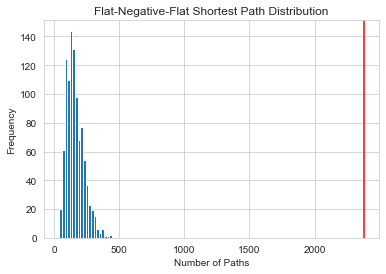

In [31]:
plt.hist(null_dist()[('F', 'N', 'F')], 20)
plt.title("Flat-Negative-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'N', 'F')], color = 'r')

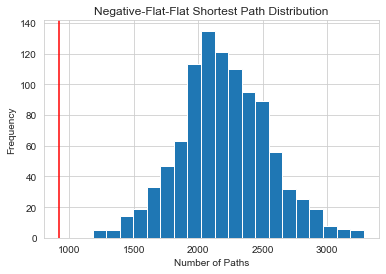

In [32]:
plt.hist(null_dist()[('N', 'F', 'F')], 20)
plt.title("Negative-Flat-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('N', 'F', 'F')], color = 'r')

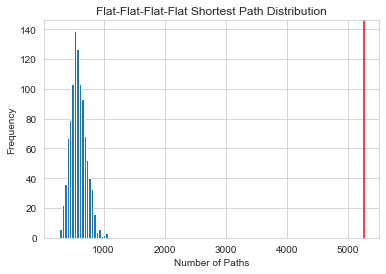

In [33]:
plt.hist(null_dist()[('F', 'F', 'F', 'F')], 20)
plt.title("Flat-Flat-Flat-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'F', 'F')], color = 'r')

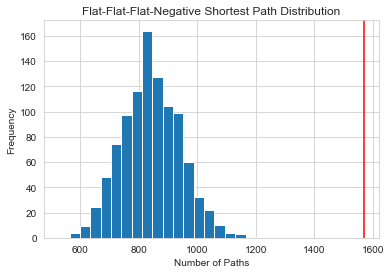

In [34]:
plt.hist(null_dist()[('F', 'F', 'F', 'N')], 20)
plt.title("Flat-Flat-Flat-Negative Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'F', 'N')], color = 'r')

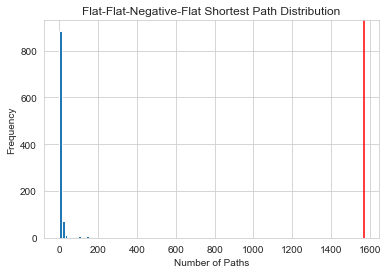

In [35]:
plt.hist(null_dist()[('F', 'F', 'N', 'F')], 20)
plt.title("Flat-Flat-Negative-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'F', 'N')], color = 'r')

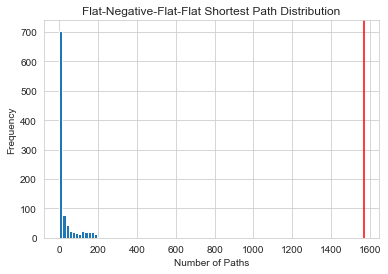

In [37]:
plt.hist(null_dist()[('F', 'N', 'F', 'F')], 20)
plt.title("Flat-Negative-Flat-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'F', 'N')], color = 'r')

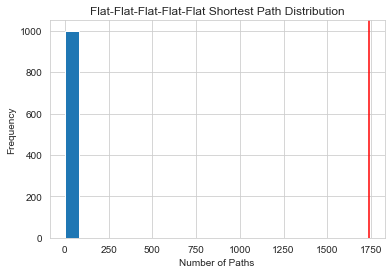

In [36]:
plt.hist(null_dist()[('F', 'F', 'F', 'F', 'F')], 1)
plt.title("Flat-Flat-Flat-Flat-Flat Shortest Path Distribution")
plt.xlabel("Number of Paths")
plt.ylabel("Frequency")
plt.axvline(x = count_short_patt[('F', 'F', 'F', 'F', 'F')], color = 'r')

## Understanding Why Above Plots Occur

(array([0.0000e+00, 2.7200e+02, 4.3880e+03, 3.6895e+04, 2.5455e+04,
        2.3740e+03, 3.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <BarContainer object of 10 artists>)

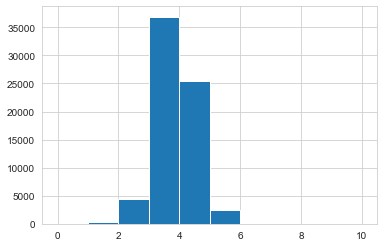

In [210]:
import statistics
plt.hist([len(path) for path in get_all_shortest_paths(G_orc)], [0,1,2,3,4,5,6,7,8,9,10])

3.771839345395874

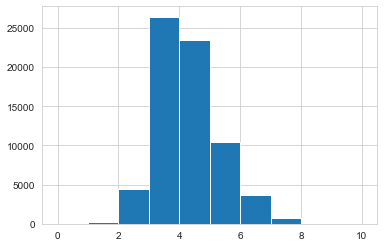

In [209]:
plt.hist([len(path) for path in get_all_shortest_paths(Elegans_orc)], [0,1,2,3,4,5,6,7,8,9,10])
statistics.mean([len(path) for path in get_all_shortest_paths(Elegans_orc)])